In [1]:
from utils.GenerateGraphMatrices import GenerateGraphMatrices, StrengthAlter
from utils.Simulator import Simulator
from utils.ImmunizationPolicies import Policy
import json, os, math, scipy
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
%matplotlib inline

In [2]:
home_dir = os.environ['GDMPATH']+'/'
data_dir = "datasets/"
results_dir = "results/"
with open(home_dir+"hyper_params.json") as f:
    hyper = json.load(f)

In [ ]:
def plot_beta(G1, G2, alpha):
    beta = [i/100 for i in range(1,100,2)]
    axis = [i for i in range(0, len(beta))]
    EffStren = []
    check=True
    for i in axis:
        S1 = G1.GenSystemMatrix(alpha, beta[i])
        S2 = G1.GenSystemMatrix(alpha, beta[i])
        EffStren.append(abs(StrengthAlter(S1, S2).value(n=1)[0]))
        if (EffStren[i] > 1.0 and check==True):
            print("Minimum Transmisssion Probablity for an Epidemic is {}".format(beta[i]))
            check=False
    plt.plot(beta, EffStren)
    plt.title('Effective Strength plot by varying Transmission Probablity (Under Hp={})'.format(alpha))
    plt.axhline(y=1,linestyle='--',linewidth=3,color='red')
    plt.xlabel("Transmission Probability -->")
    plt.ylabel("Effective Strength Value -->")
    plt.show()
    return None

def plot_alpha(G1, G2, beta):
    alpha = [i/100 for i in range(1,100, 2)]
    axis = [i for i in range(0, len(alpha))]
    print(len(alpha), len(axis))
    EffStren = []
    check=True
    for i in axis:
        S1 = G1.GenSystemMatrix(alpha[i], beta)
        S2 = G1.GenSystemMatrix(alpha[i], beta)
        EffStren.append(abs(StrengthAlter(S1, S2).value(n=1)[0]))
        if (EffStren[i] < 1.0 and check==True):
            print("Maximum Healing Probablity for an Epidemic is {}".format(alpha[i]))
            check=False
    plt.plot(alpha, EffStren)
    plt.title('Effective Strength plot by varying Healing Probablity (Under Tp={})'.format(beta))
    plt.axhline(y=1,linestyle='--',linewidth=3,color='red')
    plt.xlabel("Healing Probability -->")
    plt.ylabel("Effective Strength Value -->")
    plt.show()
    return EffStren

In [ ]:
G1 = GenerateGraphMatrices()
G1.GenGraphObj(EdgeFilePath=home_dir+data_dir+"alternating/alternating1.network")

G2 = GenerateGraphMatrices()
G2.GenGraphObj(EdgeFilePath=home_dir+data_dir+"alternating/alternating2.network")

S11 = G1.GenSystemMatrix(hyper['alpha']['1'], hyper['beta']['1'])
S12 = G2.GenSystemMatrix(hyper['alpha']['1'], hyper['beta']['2'])
EffStren1 = StrengthAlter(S11, S11).value(n=1)

S21 = G2.GenSystemMatrix(hyper['alpha']['2'], hyper['beta']['2'])
S22 = G2.GenSystemMatrix(hyper['alpha']['2'], hyper['beta']['2'])
EffStren2 = StrengthAlter(S12, S22).value(n=1)

# print('Note: Tp => Transmission Probability, Hp => Healing Probability')
# print("\n")
# print('Using Tp1 : {}, Tp2 : {}'.format(hyper['beta']['1'], hyper['beta']['2']))
# print('Effective Strength: {}'.format(abs(EffStren1[0])))
# print("\n")
# print('Using Hp1 : {}, Hp2 : {}'.format(hyper['alpha']['1'], hyper['alpha']['2']))
# print('Effective Strength: {}'.format(abs(EffStren2[0])))

plot_beta(G1, G2, alpha=0.70)
plot_beta(G1, G2, alpha=0.20)
plot_alpha(G1, G2, beta=0.20)
plot_alpha(G1, G2, beta=0.01)

Simulation has been completed
Simulation has been completed
Simulation has been completed
Simulation has been completed
Simulation has been completed
Simulation has been completed
Simulation has been completed
Simulation has been completed
Simulation has been completed
Simulation has been completed
(10, 101)


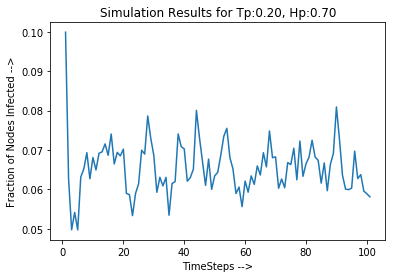

In [3]:
A1 = home_dir+"datasets/alternating/alternating1.network"
A2 = home_dir+"datasets/alternating/alternating2.network"
Simulate = Simulator(A1, A2, results_dir)
Results = []
for i in range(0,10):
    Simulate.start(100, float(hyper['alpha']['1']), float(hyper['beta']['1']))
    Results.append(list(list(Simulate.give_stats().values())[0].values()))
arr = np.array(Results)
print(arr.shape)
arr = np.average(arr, axis=0)
plt.plot([i for i in range(1, arr.shape[0]+1)], arr.tolist())
plt.title('Simulation Results for Tp:{}, Hp:{}'.format(hyper['beta']['1'], hyper['alpha']['1']))
plt.xlabel("TimeSteps -->")
plt.ylabel("Fraction of Nodes Infected -->")
plt.show()

In [ ]:
A1 = home_dir+"datasets/alternating/alternating1.network"
A2 = home_dir+"datasets/alternating/alternating2.network"
Simulate = Simulator(A1, A2, results_dir)
Results = []
for i in range(0,10):
    Simulate.start(100, float(hyper['alpha']['2']), float(hyper['beta']['2']))
    Results.append(list(list(Simulate.give_stats().values())[0].values()))
arr = np.array(Results)
arr = np.average(arr, axis=0)
plt.plot([i for i in range(1, arr.shape[0]+1)], arr.tolist())
plt.title('Simulation Results for Tp:{}, Hp:{}'.format(hyper['beta']['2'], hyper['alpha']['2']))
plt.xlabel("TimeSteps -->")
plt.ylabel("Fraction of Nodes Infected -->")
plt.show()

In [4]:
def custom(G1, G2, alpha, beta):
    Adj1 = nx.to_scipy_sparse_matrix(G1, format='csc')
    Adj2 = nx.to_scipy_sparse_matrix(G2, format='csc')
    Identity = scipy.sparse.identity(G1.number_of_nodes(), format='csc')
    S1 = Identity.multiply(1-float(alpha)) + Adj1.multiply(float(beta))
    S2 = Identity.multiply(1-float(alpha)) + Adj2.multiply(float(beta))
    return StrengthAlter(S1, S2).value()

In [5]:
# Finding Effective Sterength after Immunization:
results_dir = home_dir+"results/sim_results"
A1 = home_dir+"datasets/alternating/alternating1.network"
A2 = home_dir+"datasets/alternating/alternating2.network"

Simulate = Simulator(A1, A2, results_dir)
Simulate.initialize()
infected_nodes = Simulate.start(100, float(hyper['alpha']['1']), float(hyper['beta']['1']))

print("..........................................Policy A...........................................................")

Immunize = Policy(A1, A2, results_dir)
Immunize.A(200, float(hyper['alpha']['1']), float(hyper['beta']['1']), infected_nodes, results_dir, 20)
G1 = Immunize.Graph1
G2 = Immunize.Graph2
print(abs(custom(G1, G2, float(hyper['alpha']['1']), float(hyper['beta']['1']))))

print("..........................................Policy B...........................................................")

Immunize = Policy(A1, A2, results_dir)
Immunize.B(200, float(hyper['alpha']['1']), float(hyper['beta']['1']), infected_nodes, results_dir, 20)
G1 = Immunize.Graph1
G2 = Immunize.Graph2
print(abs(custom(G1, G2, float(hyper['alpha']['1']), float(hyper['beta']['1']))))

print("..........................................Policy C...........................................................")

Immunize = Policy(A1, A2, results_dir)
Immunize.C(200, float(hyper['alpha']['1']), float(hyper['beta']['1']), infected_nodes, results_dir, 20)
G1 = Immunize.Graph1
G2 = Immunize.Graph2
print(abs(custom(G1, G2, float(hyper['alpha']['1']), float(hyper['beta']['1']))))

print("..........................................Policy D...........................................................")

Immunize = Policy(A1, A2, results_dir)
Immunize.D(200, float(hyper['alpha']['1']), float(hyper['beta']['1']), infected_nodes, results_dir, 20)
G1 = Immunize.Graph1
G2 = Immunize.Graph2
print(abs(custom(G1, G2, float(hyper['alpha']['1']), float(hyper['beta']['1']))))

Simulation has been completed
..........................................Policy A...........................................................
Before Immunization: 459
After Immunization: 447
[77.67849589]
..........................................Policy B...........................................................
Before Immunization: 459
After Immunization: 424
[1.08098485]
..........................................Policy C...........................................................
Before Immunization: 459
200 271
After Immunization: 425
[1.04681282]
..........................................Policy D...........................................................
Before Immunization: 459
After Immunization: 436
[55.4157022]


In [6]:
A1 = home_dir+"datasets/alternating/alternating1.network"
A2 = home_dir+"datasets/alternating/alternating2.network"
Simulate = Simulator(A1, A2, results_dir)
infected_nodes = Simulate.start(100, float(hyper['alpha']['1']), float(hyper['beta']['1']))

Simulation has been completed


Before Immunization: 468
After Immunization: 451
Before Immunization: 468
After Immunization: 444
Before Immunization: 468
After Immunization: 442
Before Immunization: 468
After Immunization: 432
Before Immunization: 468
After Immunization: 426
Before Immunization: 468
After Immunization: 425
Before Immunization: 468
After Immunization: 380
Before Immunization: 468
After Immunization: 466
Before Immunization: 468
After Immunization: 413
Before Immunization: 468
After Immunization: 457
Before Immunization: 468
After Immunization: 349
Before Immunization: 468
After Immunization: 457
Before Immunization: 468
After Immunization: 388
Before Immunization: 468
After Immunization: 340
Before Immunization: 468
After Immunization: 386
Before Immunization: 468
After Immunization: 385
Before Immunization: 468
After Immunization: 389
Before Immunization: 468
After Immunization: 367
Before Immunization: 468
After Immunization: 445
Before Immunization: 468
After Immunization: 444
Before Immunization:

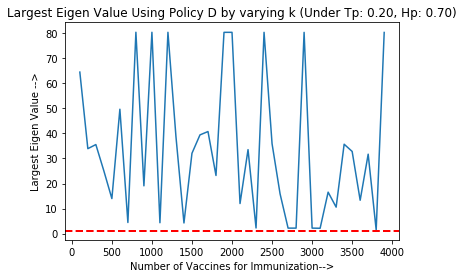

In [15]:
Results = []
axis = []
for k in range(100,4000,100):
    Immunize = Policy(A1, A2, results_dir)
    Immunize.D(k, float(hyper['alpha']['1']), float(hyper['beta']['1']), infected_nodes, results_dir, 20)
    G1 = Immunize.Graph1
    G2 = Immunize.Graph2
    try:
        Results.append(abs(custom(G1, G2, float(hyper['alpha']['1']), float(hyper['beta']['1'])))[0])
        axis.append(k)
    except:
        print("Failed for the value k : " + str(k))
plt.plot(axis, Results)
plt.title('Largest Eigen Value Using Policy D by varying k (Under Tp: {}, Hp: {})'.format(hyper['beta']['1'], hyper['alpha']['1']))
plt.xlabel("Number of Vaccines for Immunization-->")
plt.ylabel("Largest Eigen Value -->")
plt.axhline(y=1,linestyle='--',linewidth=2,color='red')
plt.show()

In [12]:
print(Results)

[2.3087104808836485, 1.080984850158616, 0.799286484130749, 0.6739968588206169, 0.5917125590357122, 0.5784441020371199, 0.5419772982141716, 0.48999999999999905, 0.48358344003390047, 0.4835834400339007, 0.4835834400338997, 0.4835834400338991, 0.4835834400338985, 0.3467122967388296, 0.34671229673883086, 0.3467122967388309, 0.3467122967388301, 0.34671229673883, 0.34671229673883075]


In [ ]:
print(axis)